In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import os

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
from xskillscore import rmse

warnings.filterwarnings("ignore")

## Getting Data Ready

In [2]:
# Get all best model results for validation
files = glob('results/validations/*')

# split the files into mean and std
gp_means_fp = sorted([f for f in files if 'mean' in f])
gp_std_fp = sorted([f for f in files if 'std' in f])

In [3]:
variables = ['dtr', 'pr', 'pr90', 'tas'] # variables in alphabetical order

# Getting predictions from GP mean
gp_means_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_means_fp)
}

# Getting predictions from GP std
gp_std_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_std_fp)
}

In [4]:
# Get data from Reproduction
files = glob('results/validations_repo/*')

# split the files into mean and std
gp_means_repo_fp = sorted([f for f in files if 'mean' in f])
gp_std_repo_fp = sorted([f for f in files if 'std' in f])

# Getting predictions from repo GP mean
gp_means_repo_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_means_repo_fp)
}

# Getting predictions from repo GP std
gp_std_repo_data = {
    var: xr.open_dataarray(f) for var, f in zip(variables, gp_std_repo_fp)
}

In [5]:
# Get the observed data
Y = xr.open_dataset('results/validations/outputs_ssp245.nc')

# rename diundamental temperature range to dtr for consistency
Y = Y.rename({'diurnal_temperature_range': 'dtr'})

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400
Y = Y.mean('member')
NorESM_data = {
    var: Y[var] for var in variables
}

## Making spatial plots

In [69]:
variables = ['tas', 'dtr', 'pr', 'pr90']
variables_names = ['Temperature', 'Diurnal temperature range', 'Precipitation', '90th percentile of precipitation']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
models = ['Deep Kernel Learning', 'Base GP (Reproduction)', 'NorESM2']
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

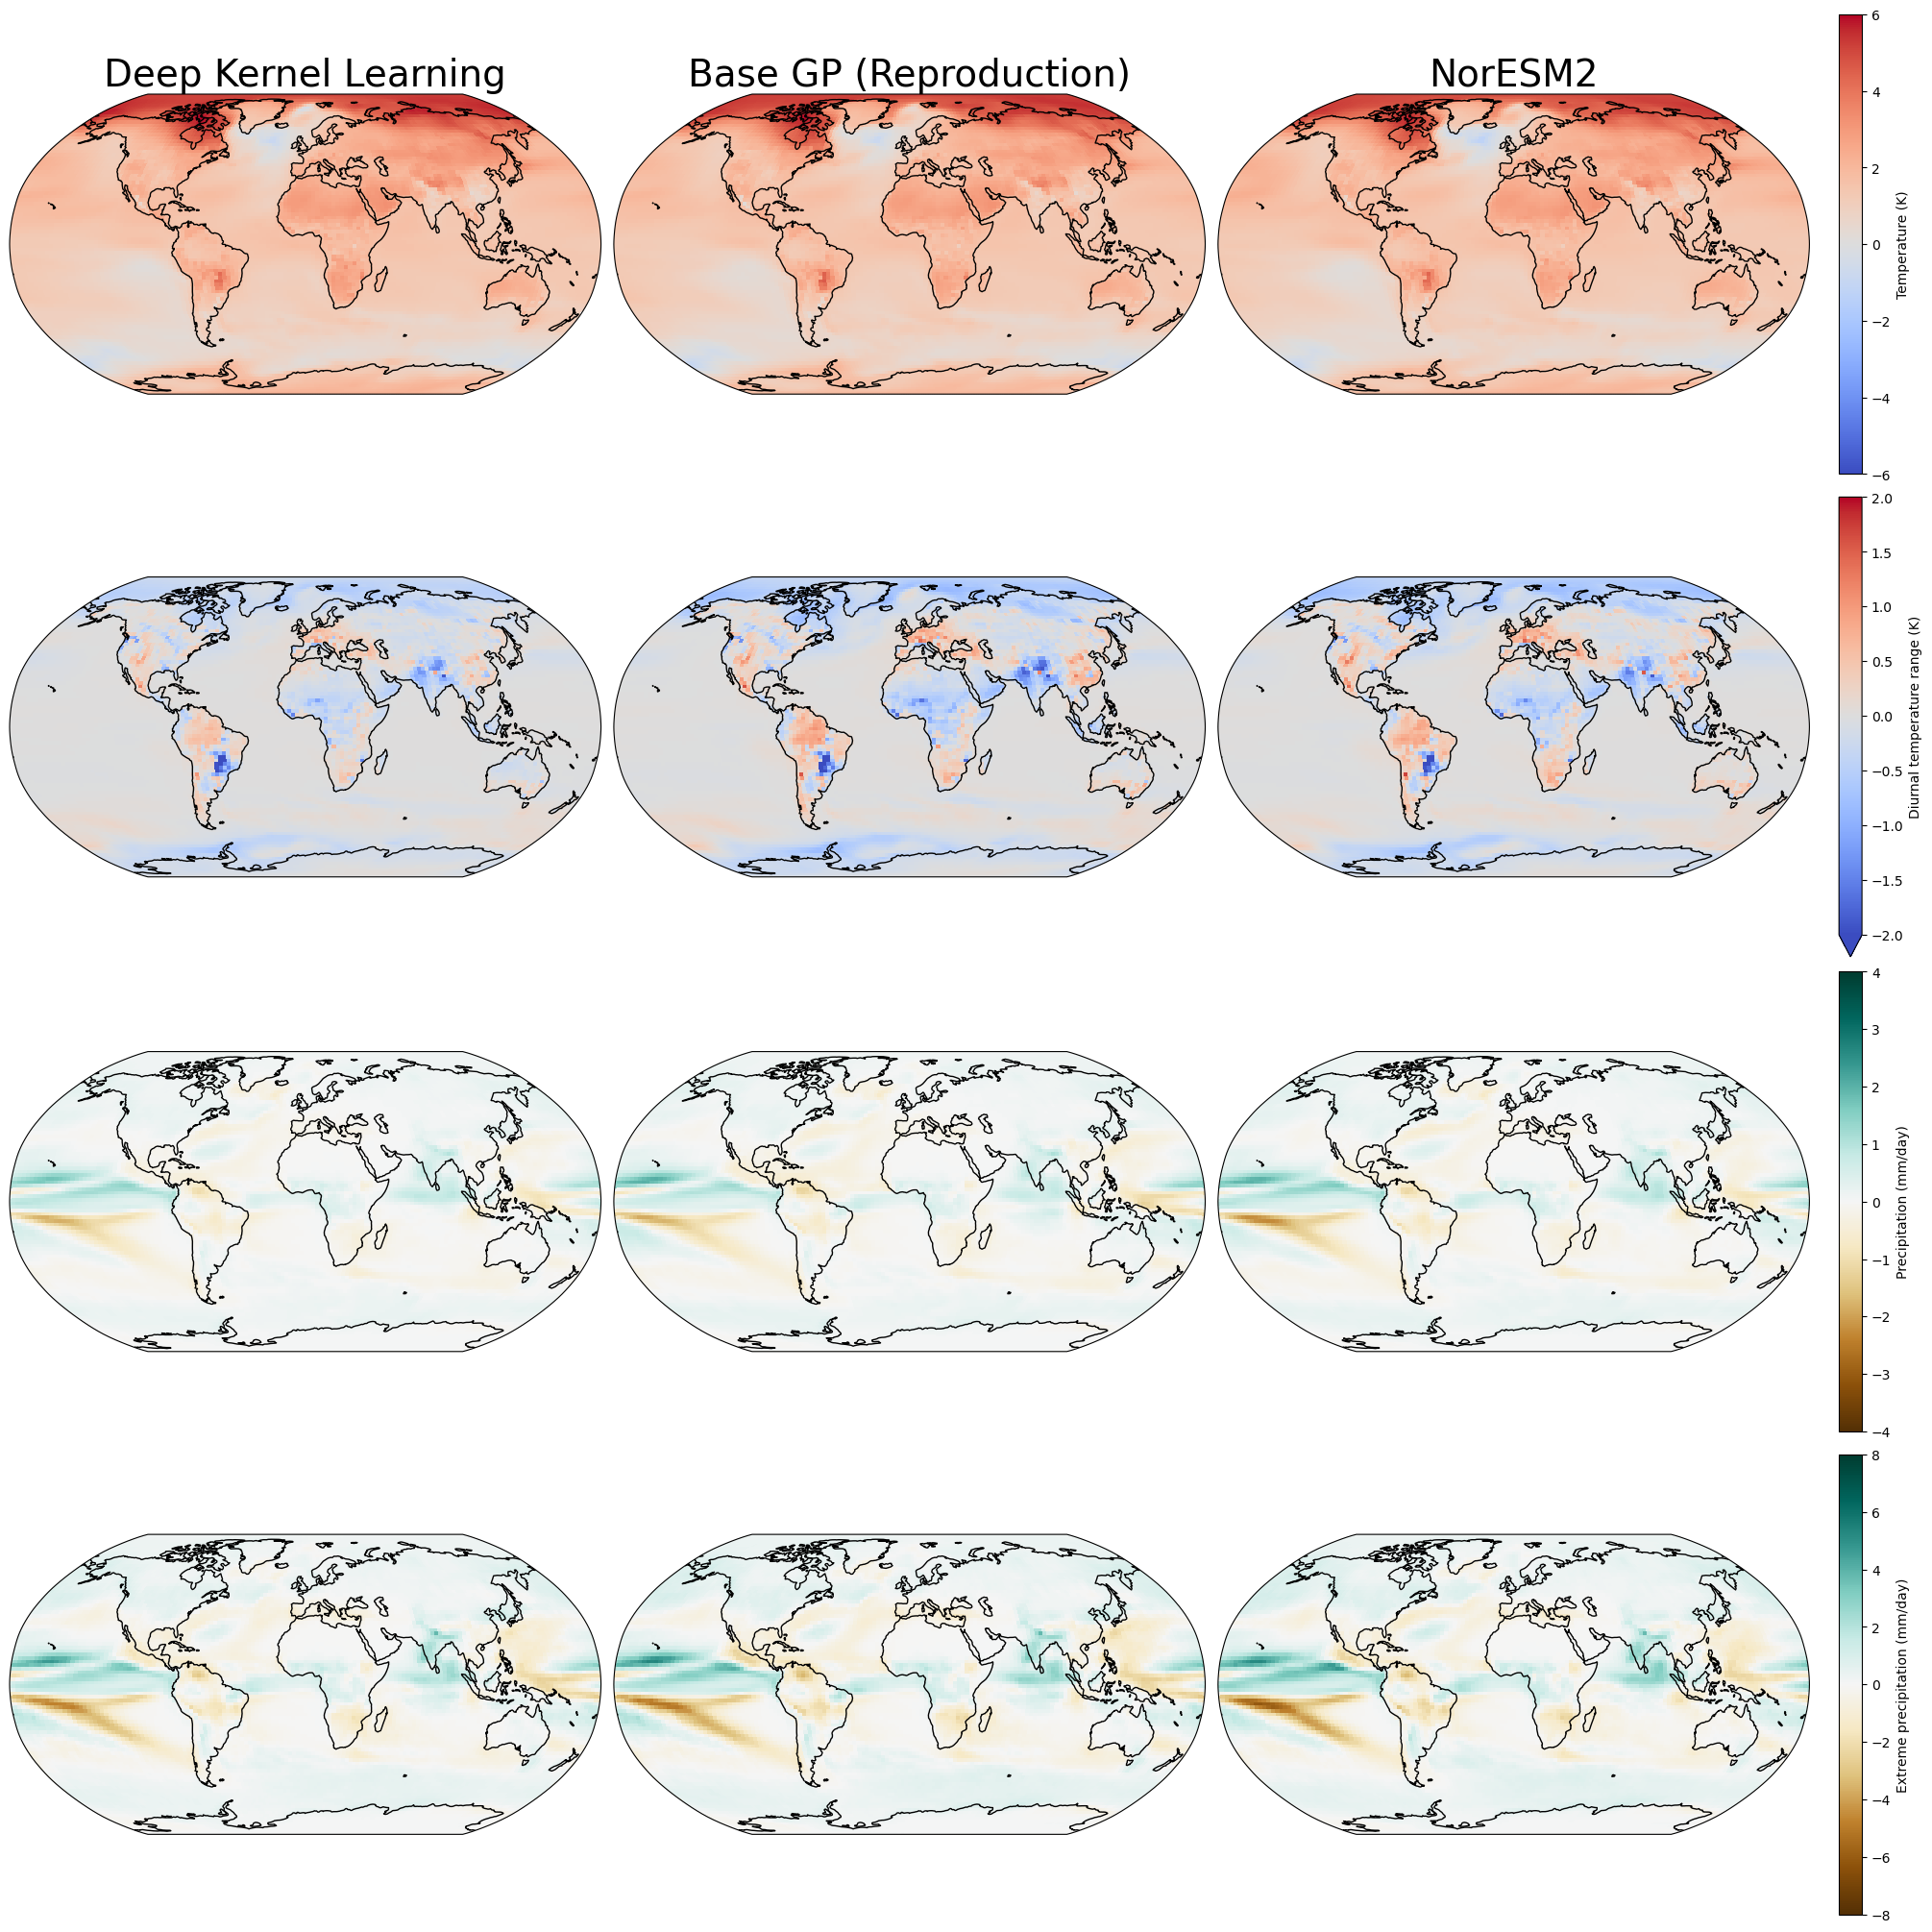

In [8]:
# Plot results one for each variable comparing with the observed data and reproduction 
fig, axes = plt.subplots(4, 3, figsize=(20, 20), subplot_kw={"projection": ccrs.Robinson()},constrained_layout=True)

for i, var in enumerate(variables):
    # Setting the axis 
    ax = axes[i, 0]
    for j, model in enumerate([gp_means_data, gp_means_repo_data, NorESM_data]):
        # Plotting the data
        if j == 2:
            model[var].mean(dim='time').plot(ax=axes[i, j], transform=ccrs.PlateCarree(), add_labels=False, cbar_kwargs={"label":labels[i], "orientation":'vertical'}, **kwargs[i])
        else:
            model[var].mean(dim='time').plot(ax=axes[i, j], transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, **kwargs[i])
        axes[i, j].coastlines()

    # Setting the title only on first row
    if i == 0:
        axes[i, 0].set_title("Deep Kernel Learning", fontsize=28)
        axes[i, 1].set_title("Base GP (Reproduction)", fontsize=28)
        axes[i, 2].set_title("NorESM2", fontsize=28)

## Evaluations Metrics

In [38]:
# Function to get different evaluation metrics
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # Calculate the weights
    weights = np.cos(np.deg2rad(truth.lat)).expand_dims(lon=144).assign_coords(lon=truth.lon)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(4)
    R2E = R2E.T.round(4)
    NRMSE = NRMSE.T.round(4)
    return R2E, NRMSE, total

In [39]:
eval_metrics_2080_2100 = {
    'Deep Kernel Learning': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
    'Base GP (Reproduction)': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
}
eval_metrics_2015_2100 = {
    'Deep Kernel Learning': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
    'Base GP (Reproduction)': pd.DataFrame(columns=['R2E', 'NRMSE', 'Total']),
}

for i, var in enumerate(variables):
    # Get the scores
    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_data[var])
    print(f"Deep Kernel Learning {var} R2E (2080-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2080_2100['Deep Kernel Learning'].loc[var] = [R2E, NRMSE, total]
    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_data[var], Yearslice=slice(2015, None))
    print(f"Deep Kernel Learning {var} R2E (2015-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2015_2100['Deep Kernel Learning'].loc[var] = [R2E, NRMSE, total]

    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_repo_data[var])
    print(f"Base GP (Reproduction) {var} R2E (2080-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2080_2100['Base GP (Reproduction)'].loc[var] = [R2E, NRMSE, total]
    R2E, NRMSE, total = TNRMSE(Y[var], gp_means_repo_data[var], Yearslice=slice(2015, None))
    print(f"Base GP (Reproduction) {var} R2E (2015-2100): {R2E}, NRMSE: {NRMSE}, Total: {total}")
    eval_metrics_2015_2100['Base GP (Reproduction)'].loc[var] = [R2E, NRMSE, total]

    print("\n")

Deep Kernel Learning tas R2E (2080-2100): 0.0895, NRMSE: 0.153, Total: 0.6002
Deep Kernel Learning tas R2E (2015-2100): 0.1047, NRMSE: 0.0813, Total: 0.6049
Base GP (Reproduction) tas R2E (2080-2100): 0.0437, NRMSE: 0.0906, Total: 0.3089
Base GP (Reproduction) tas R2E (2015-2100): 0.0587, NRMSE: 0.0694, Total: 0.3626


Deep Kernel Learning dtr R2E (2080-2100): 2.2797, NRMSE: 9.8553, Total: 21.2536
Deep Kernel Learning dtr R2E (2015-2100): 0.582, NRMSE: 2.7579, Total: 5.6681
Base GP (Reproduction) dtr R2E (2080-2100): 2.6495, NRMSE: 9.195, Total: 22.4425
Base GP (Reproduction) dtr R2E (2015-2100): 0.629, NRMSE: 2.1638, Total: 5.3086


Deep Kernel Learning pr R2E (2080-2100): 0.4164, NRMSE: 2.2448, Total: 4.3268
Deep Kernel Learning pr R2E (2015-2100): 0.5054, NRMSE: 2.2047, Total: 4.7316
Base GP (Reproduction) pr R2E (2080-2100): 0.3784, NRMSE: 2.3301, Total: 4.2223
Base GP (Reproduction) pr R2E (2015-2100): 0.5539, NRMSE: 3.0496, Total: 5.8189


Deep Kernel Learning pr90 R2E (2080-2100

In [46]:
# Get difference between models total score
diff_2080_2100 = eval_metrics_2080_2100['Deep Kernel Learning'] - eval_metrics_2080_2100['Base GP (Reproduction)']
diff_2015_2100 = eval_metrics_2015_2100['Deep Kernel Learning'] - eval_metrics_2015_2100['Base GP (Reproduction)']

# add the difference
eval_metrics_2080_2100['Difference'] = diff_2080_2100
eval_metrics_2015_2100['Difference'] = diff_2015_2100


combined_eval_metrics_2080_2100 = pd.concat(eval_metrics_2080_2100, axis=1)
combined_eval_metrics_2015_2100 = pd.concat(eval_metrics_2015_2100, axis=1)

In [47]:
# combine the metrics into one dataframe
all_metrics = pd.concat([combined_eval_metrics_2080_2100, combined_eval_metrics_2015_2100], keys=['2080-2100', '2015-2100'], axis=1)
all_metrics

2080-2100                                                  \
     Deep Kernel Learning                  Base GP (Reproduction)           
                      R2E   NRMSE    Total                    R2E   NRMSE   
tas                0.0895  0.1530   0.6002                 0.0437  0.0906   
dtr                2.2797  9.8553  21.2536                 2.6495  9.1950   
pr                 0.4164  2.2448   4.3268                 0.3784  2.3301   
pr90               0.5356  3.5731   6.2511                 0.3955  2.6048   

                                                    2015-2100                  \
              Difference                 Deep Kernel Learning                   
        Total        R2E   NRMSE   Total                  R2E   NRMSE   Total   
tas    0.3089     0.0458  0.0624  0.2913               0.1047  0.0813  0.6049   
dtr   22.4425    -0.3698  0.6603 -1.1889               0.5820  2.7579  5.6681   
pr     4.2223     0.0380 -0.0853  0.1045               0.5054  2.2047  4.7316   
pr90   4.5821     0.1401  0.9683  1.6690               0.6880  3.1894  6.6294   

                                                                        
     Base GP (Reproduction)                 Difference                  
                        R2E   NRMSE   Total        R2E   NRMSE   Total  
tas                  0.0587  0.0694  0.3626     0.0460  0.0119  0.2423  
dtr                  0.6290  2.1638  5.3086    -0.0470  0.5941  0.3595  
pr                   0.5539  3.0496  5.8189    -0.0485 -0.8449 -1.0873  
pr90                 0.5848  2.8952  5.8193     0.1032  0.2942  0.8101

## Checking Global Mean time series plots 

I also plan to incorporate the variance/std given by the Gaussian Process

In [48]:
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

Text(0.5, 0.98, 'Global Mean Values for each variable')

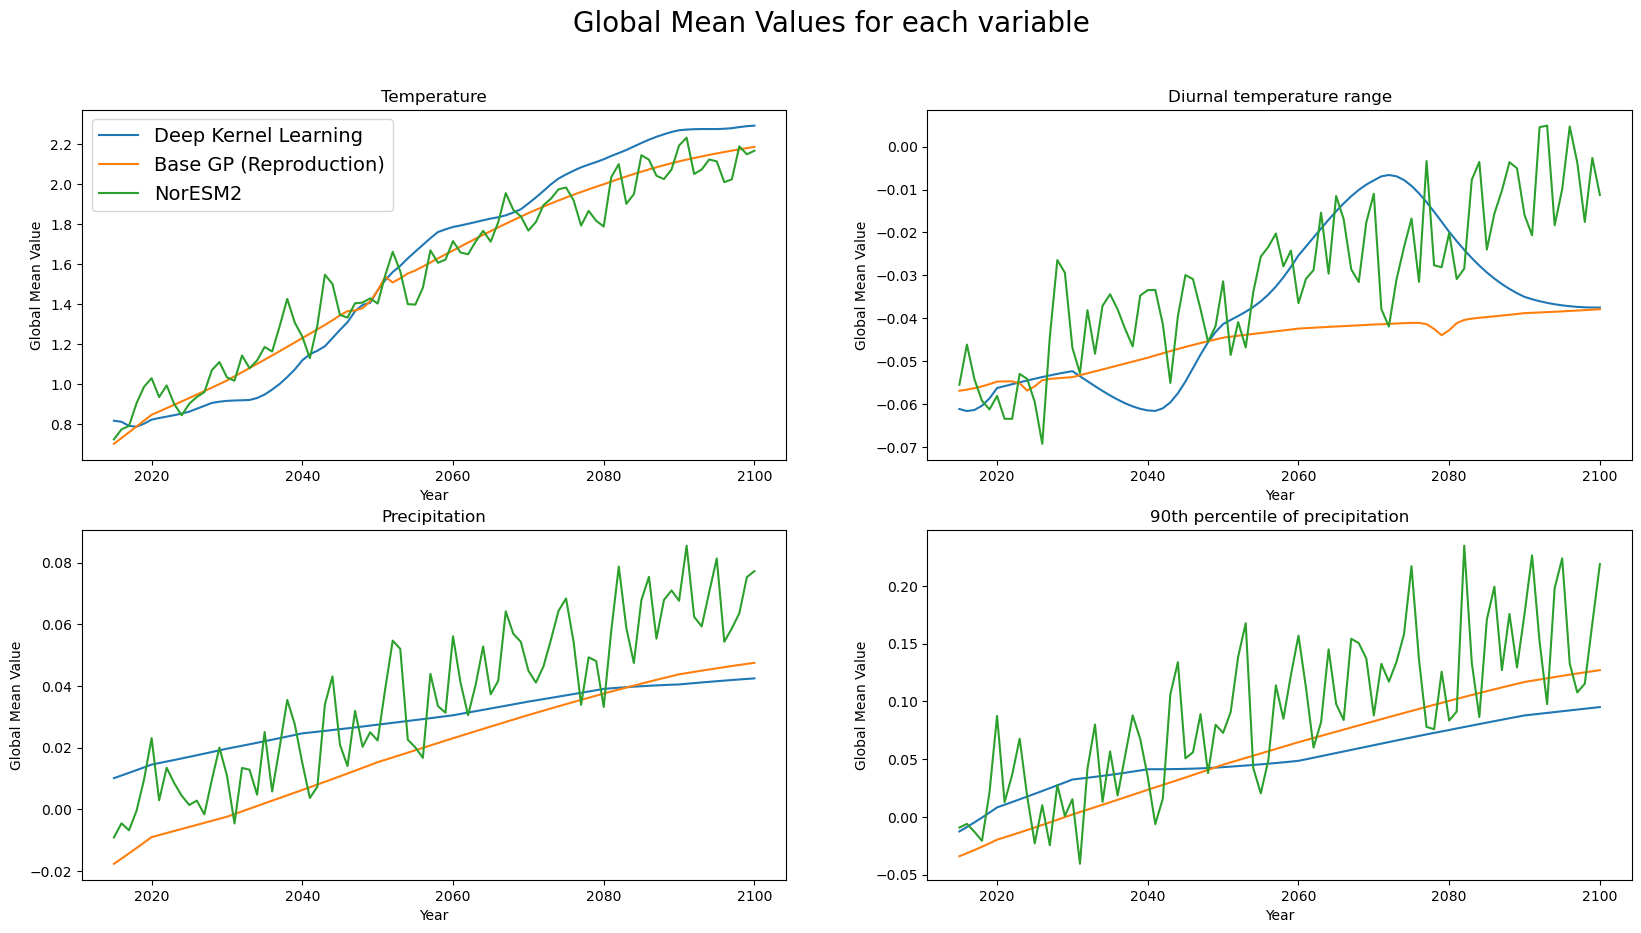

In [70]:
# 4 plots in one figure
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plotting the data
for i, var in enumerate(variables):
    axs = axes.flatten()[i]
    global_mean(gp_means_data[var]).plot(ax=axs, label='Deep Kernel Learning')
    global_mean(gp_means_repo_data[var]).plot(ax=axs, label='Base GP (Reproduction)')
    global_mean(NorESM_data[var]).plot(ax=axs, label='NorESM2')
    axs.set_title(variables_names[i])
    axs.set_ylabel('Global Mean Value')
    axs.set_xlabel('Year')
    if i == 0:
        axs.legend(fancybox=True, fontsize=14)

plt.suptitle('Global Mean Values for each variable', fontsize=20)

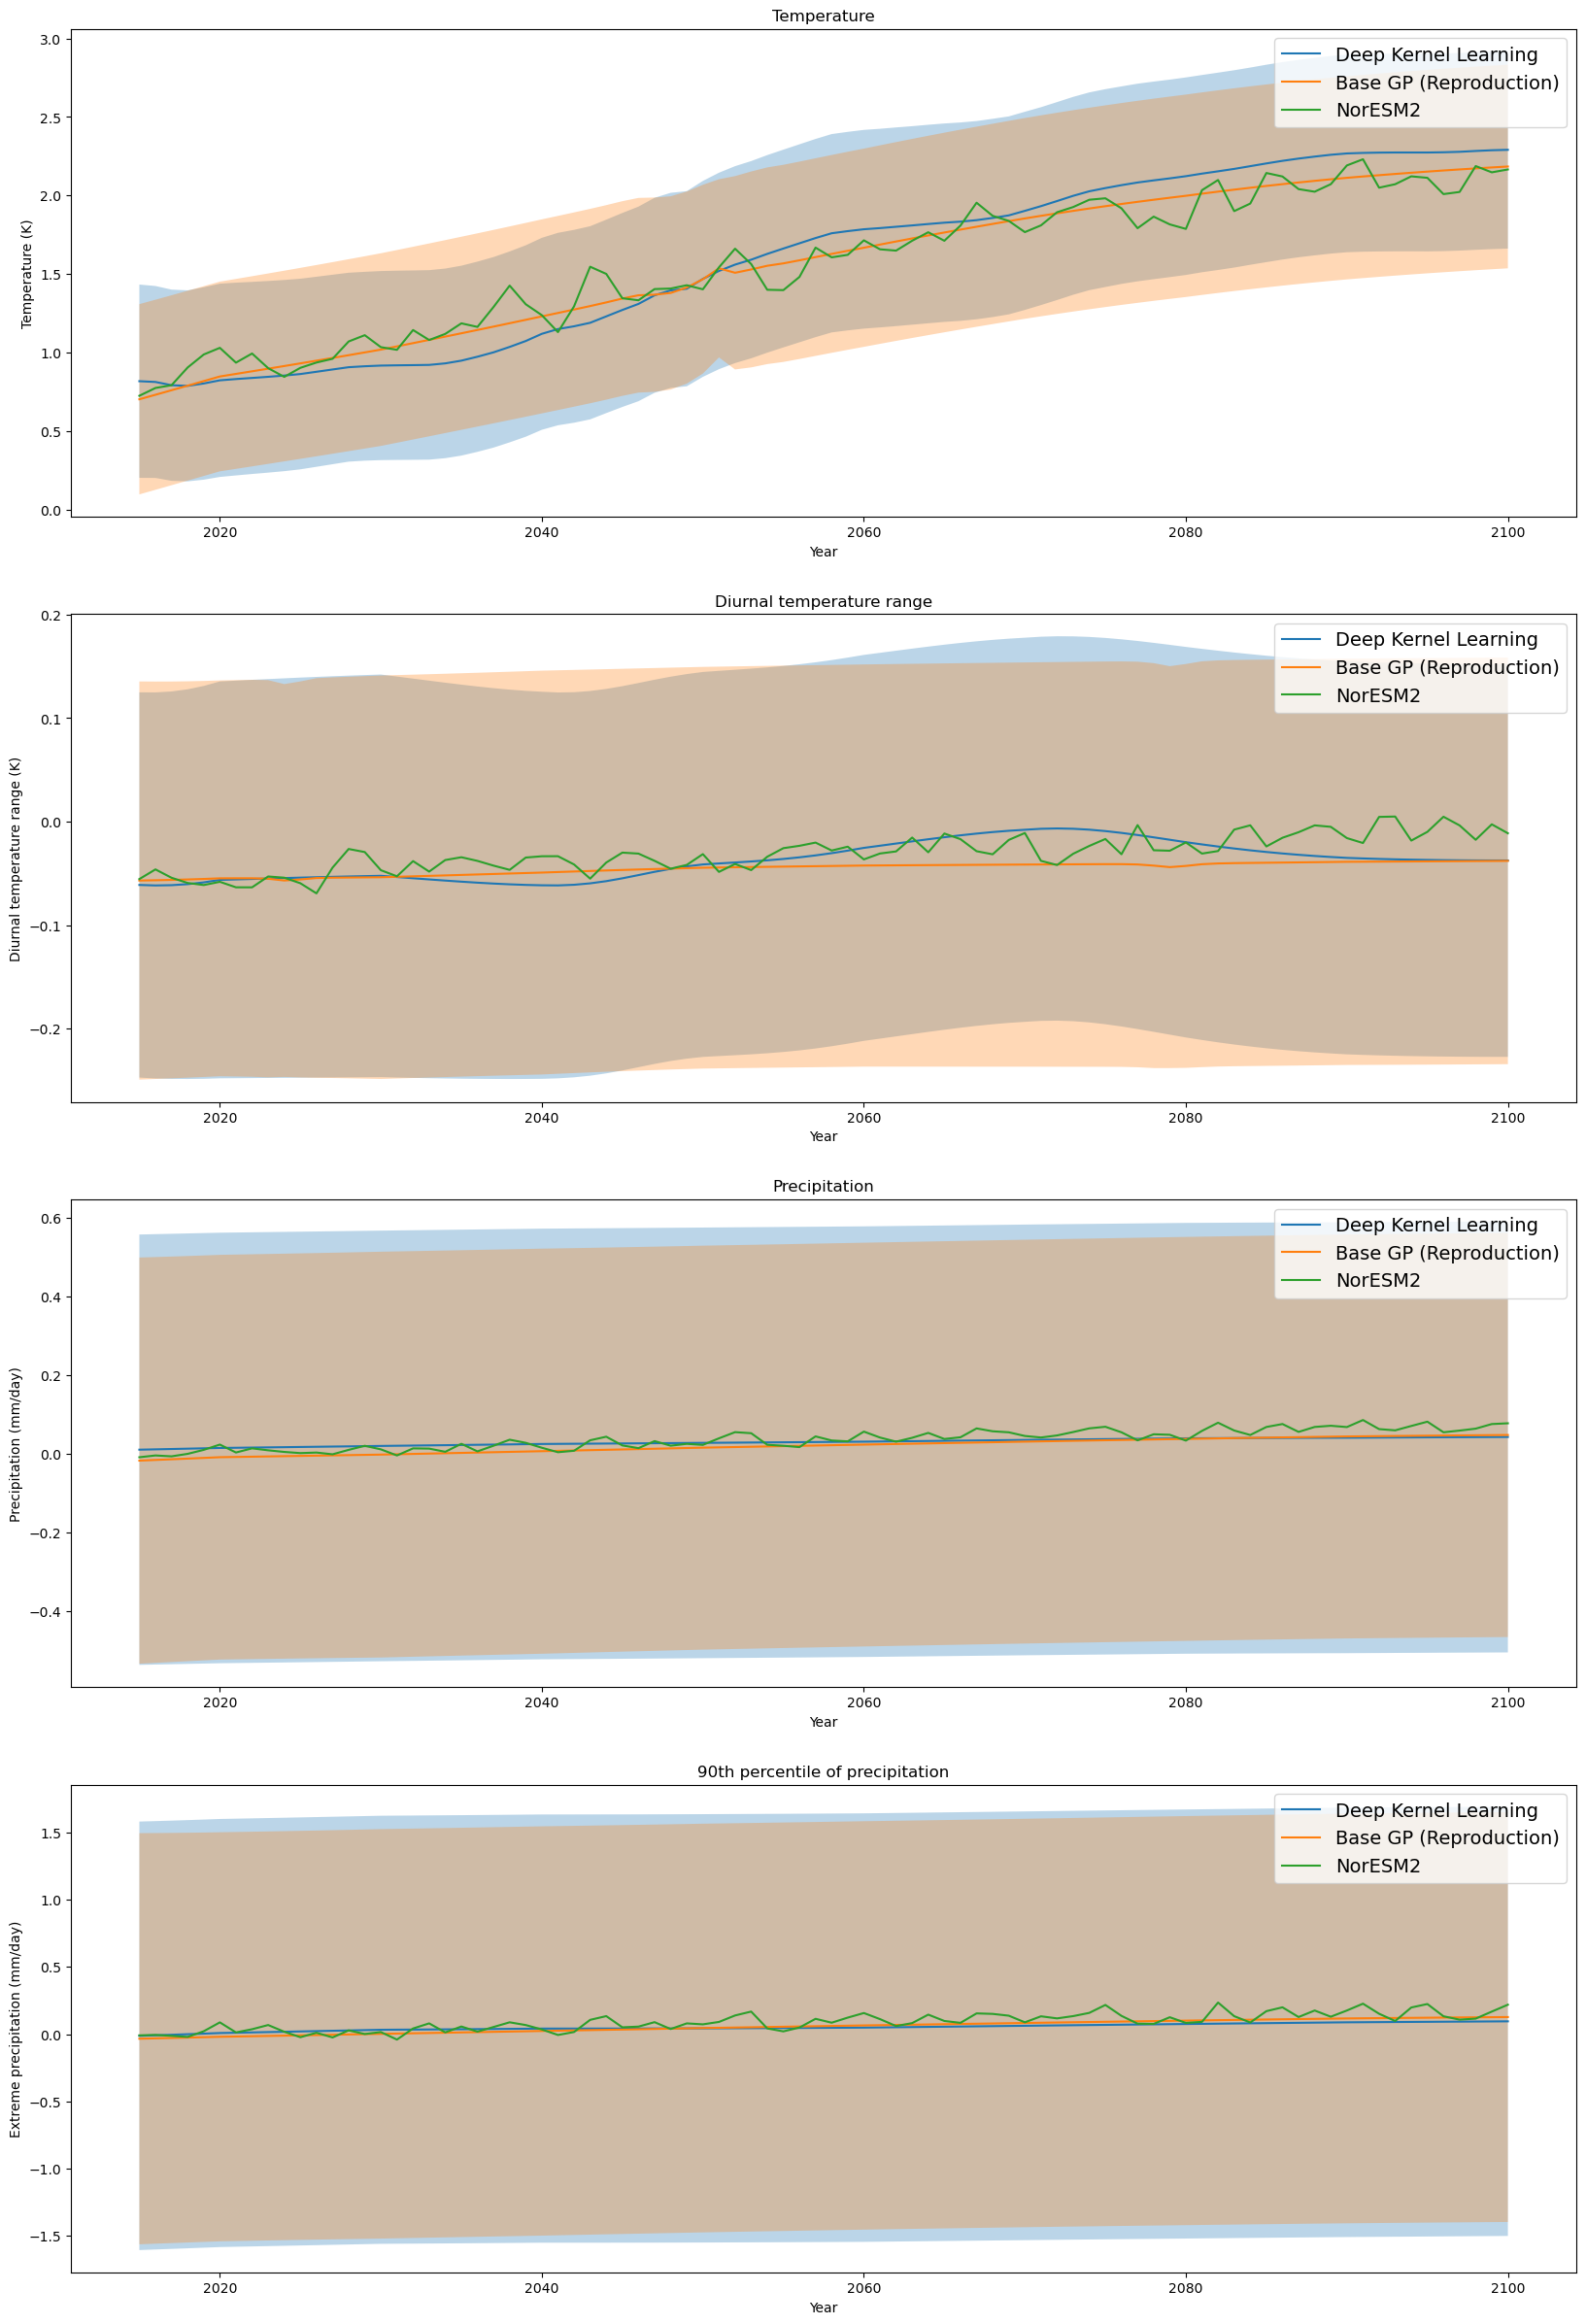

In [97]:
# Plotting time series with uncertainty test with one variable (tas)
fig, axs = plt.subplots(4, 1, figsize=(20, 30))
ylims = [(0.7, 2.4), (-0.07, 0.01), (-0.02, 0.05), (-0.05, 0.2)]

for i, var in enumerate(variables):
    ax = axs[i]
    global_mean(gp_means_data[var]).plot(ax=ax, label='Deep Kernel Learning')
    # ax.set_ylim(ylims[i])
    ax.fill_between(global_mean(gp_means_data[var]).time.data,
                    global_mean(gp_means_data[var] - gp_std_data[var]).data,
                    global_mean(gp_means_data[var] + gp_std_data[var]).data, alpha=0.3)
    
    global_mean(gp_means_repo_data[var]).plot(ax=ax, label='Base GP (Reproduction)')
    ax.fill_between(global_mean(gp_means_repo_data[var]).time.data,
                    global_mean(gp_means_repo_data[var] - gp_std_repo_data[var]).data,
                    global_mean(gp_means_repo_data[var] + gp_std_repo_data[var]).data, alpha=0.3)
    global_mean(NorESM_data[var]).plot(ax=ax, label='NorESM2')
    
    ax.set_title(variables_names[i])
    ax.set_ylabel(labels[i])
    ax.set_xlabel('Year')
    ax.legend(fancybox=True, fontsize=14)
    

## Making Interactive Map

In [7]:
Y

<xarray.Dataset>
Dimensions:   (lat: 96, lon: 144, time: 86)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
    quantile  float64 ...
Data variables:
    dtr       (time, lat, lon) float32 0.09798 0.09798 ... -0.4336 -0.4339
    tas       (time, lat, lon) float32 1.475 1.475 1.475 ... 5.264 5.264 5.266
    pr        (time, lat, lon) float32 0.03122 0.03123 0.03123 ... 0.1588 0.1588
    pr90      (time, lat, lon) float64 0.0755 0.07559 0.07565 ... 0.4201 0.4202

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
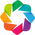

In [6]:
import os
import numpy as np
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

import holoviews as hv
from holoviews import opts, dim

import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

gv.extension('bokeh')

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [7]:
tas = Y['tas']

In [28]:
# Specify the dataset, its coordinates and requested variable 
dataset = gv.Dataset(tas, ['lon', 'lat', 'time'], 
                     'mag', crs=crs.Mollweide())
images = dataset.to(gv.Image,dynamic=True)

# Loading coastlines from Cartopy
coastline = gf.coastline(line_width=2,line_color='k').opts(projection=ccrs.PlateCarree(),scale='10m')

# Slider location
hv.output(widget_location='bottom')
images.opts(active_tools=['wheel_zoom', 'pan'], cmap='coolwarm',
            colorbar=True, width=1000, height=500, clim=(-6, 6)) * coastline 

BokehModel(combine_events=True, render_bundle={'docs_json': {'cdbdc86c-40c9-431c-9ce5-50cedfdf082b': {'version…

In [18]:
tas

<xarray.DataArray 'tas' (time: 86, lat: 96, lon: 144)>
array([[[1.4753824 , 1.4754995 , 1.4754333 , ..., 1.4753876 ,
         1.4754282 , 1.475413  ],
        [1.4822184 , 1.4778137 , 1.4732565 , ..., 1.4789581 ,
         1.4826254 , 1.4838715 ],
        [1.3079427 , 1.3219757 , 1.3363291 , ..., 1.2701721 ,
         1.2813873 , 1.291804  ],
        ...,
        [2.103485  , 2.1027222 , 2.104889  , ..., 2.103485  ,
         2.0991008 , 2.1009114 ],
        [2.2389019 , 2.237325  , 2.2364094 , ..., 2.23585   ,
         2.2373455 , 2.2379558 ],
        [2.358266  , 2.3552043 , 2.3497212 , ..., 2.3569438 ,
         2.3573406 , 2.3577168 ]],

       [[1.2637278 , 1.2639517 , 1.2639618 , ..., 1.2637024 ,
         1.2637075 , 1.2637634 ],
        [1.0221863 , 1.0289154 , 1.0362753 , ..., 1.0074972 ,
         1.0111135 , 1.0158285 ],
        [0.96910095, 0.99069214, 1.011495  , ..., 0.9227193 ,
         0.93724567, 0.9519043 ],
...
        [5.876943  , 5.8633933 , 5.8509727 , ..., 5.902954  ,
         5.89269   , 5.8875732 ],
        [5.9228616 , 5.913513  , 5.9022927 , ..., 5.9509583 ,
         5.9421387 , 5.930288  ],
        [5.9937644 , 5.9912515 , 5.9868774 , ..., 5.992859  ,
         5.993042  , 5.993418  ]],

       [[2.8937428 , 2.8941193 , 2.8941243 , ..., 2.8936818 ,
         2.8936818 , 2.8937123 ],
        [2.9665527 , 2.9758403 , 2.9842784 , ..., 2.9415538 ,
         2.9492798 , 2.95755   ],
        [2.906128  , 2.9335175 , 2.960673  , ..., 2.813258  ,
         2.8421783 , 2.8742268 ],
        ...,
        [4.75058   , 4.7525125 , 4.757731  , ..., 4.7245994 ,
         4.734202  , 4.74293   ],
        [5.003723  , 5.0000205 , 4.9972024 , ..., 5.0043945 ,
         5.0058494 , 5.00411   ],
        [5.266866  , 5.264038  , 5.2586465 , ..., 5.2635903 ,
         5.2644553 , 5.2655945 ]]], dtype=float32)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
    quantile  float64 ...